# Die assembly

With gdsfactory you can easily go from a simple Component, to a Component with many components inside.

In the same way that you need to Layout for DRC (Design Rule Check) clean devices, you have to layout obeying the Design for Test (DFT) and Design for Packaging rules.

## Design for test

To measure your chips after fabrication you need to decide your test configurations. This includes Design For Testing Rules like:

- `Individual input and output fibers` versus `fiber array`. You can use `add_fiber_array` for easier testing and higher throughput, or `add_fiber_single` for the flexibility of single fibers.
- Fiber array pitch (127um or 250um) if using a fiber array.
- Pad pitch for DC and RF high speed probes (100, 125, 150, 200um). Probe configuration (GSG, GS ...)
- Test layout for DC, RF and optical fibers.


In [ ]:
from functools import partial

import gdsfactory as gf
from gdsfactory.labels.add_label_yaml import add_label_json

2025-03-27 14:43:28.315 | INFO     | kfactory.kcell:show:3391 - klive v0.3.3: Reloaded file '/home/nynra/repos/pytools-lithography/pytools-litho-design/build/gds/537226451.oas'
2025-03-27 14:43:28.514 | INFO     | kfactory.kcell:show:3391 - klive v0.3.3: Reloaded file '/home/nynra/repos/pytools-lithography/pytools-litho-design/build/gds/1703357012.oas'
2025-03-27 14:43:28.802 | INFO     | kfactory.kcell:show:3391 - klive v0.3.3: Reloaded file '/home/nynra/repos/pytools-lithography/pytools-litho-design/build/gds/577437226.oas'


## Pack

Lets start with a resistance sweep, where you change the resistance width to measure sheet resistance.

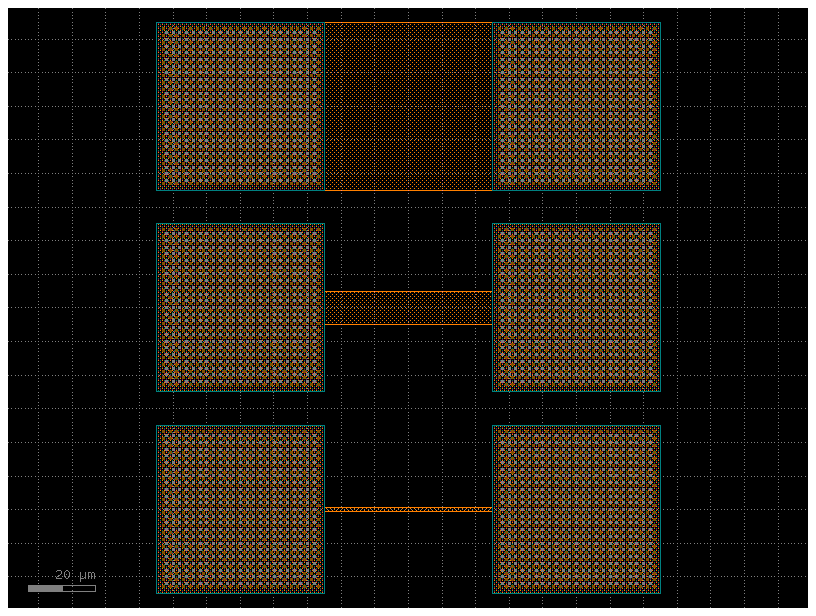

In [2]:
sweep = [gf.components.resistance_sheet(width=width) for width in [1, 10, 50]]
m = gf.pack(sweep)
c = m[0]
c.plot()

Then we add spirals with different lengths to measure waveguide propagation loss. You can use both fiber array or single fiber.

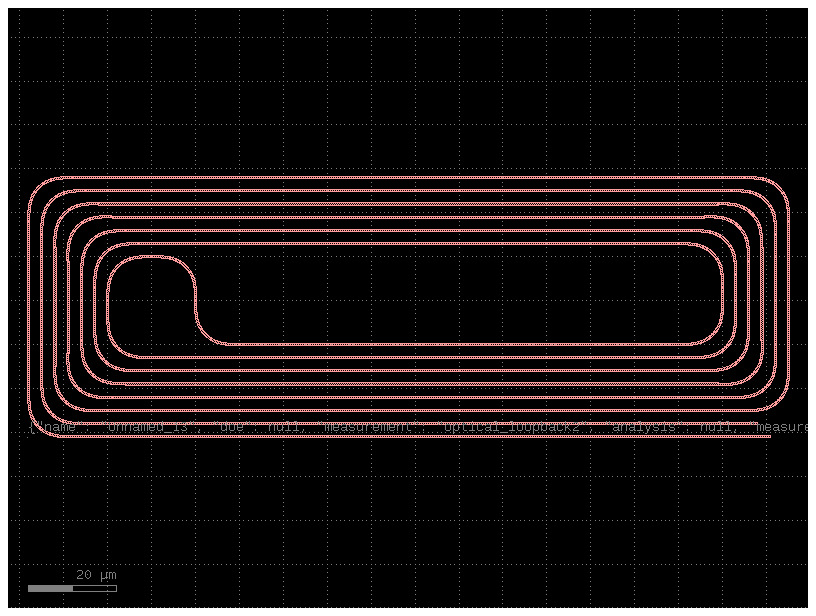

In [3]:
import gdsfactory as gf

gf.config.rich_output()

c = gf.Component()
d = c << gf.components.spiral(length=100)
c.info["measurement"] = "optical_loopback2"
c = add_label_json(c)
c.plot()

In [4]:
c.info

Info(measurement='optical_loopback2')

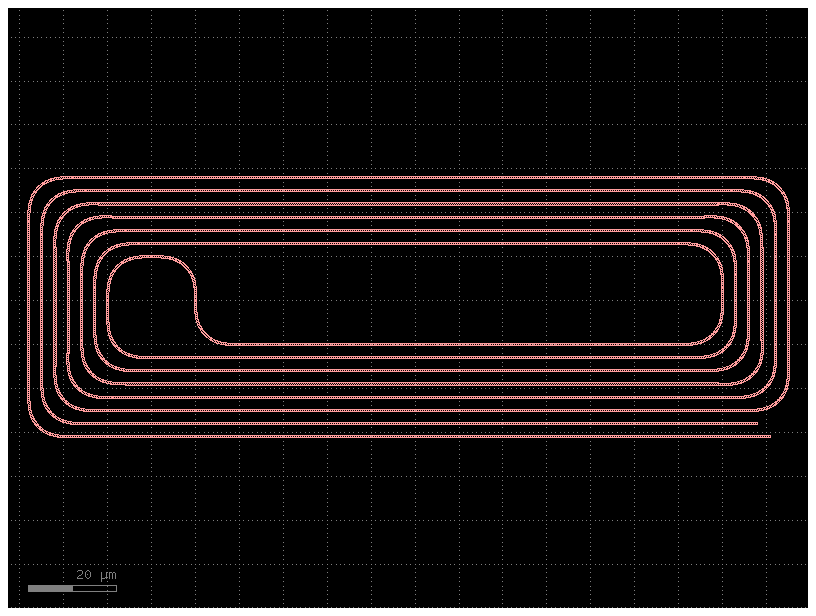

In [5]:
spiral = gf.components.spiral()
spiral.plot()

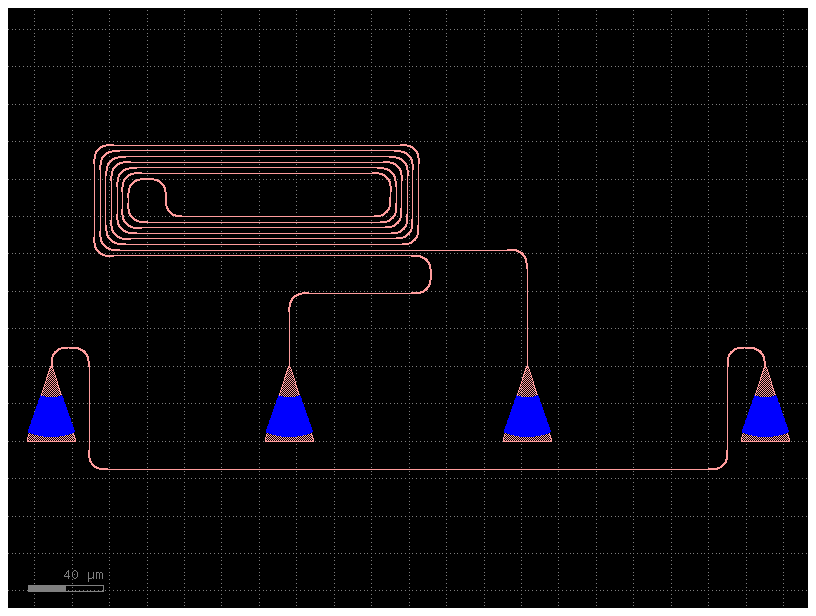

In [6]:
spiral_te = gf.routing.add_fiber_array(gf.components.spiral)
spiral_te.plot()

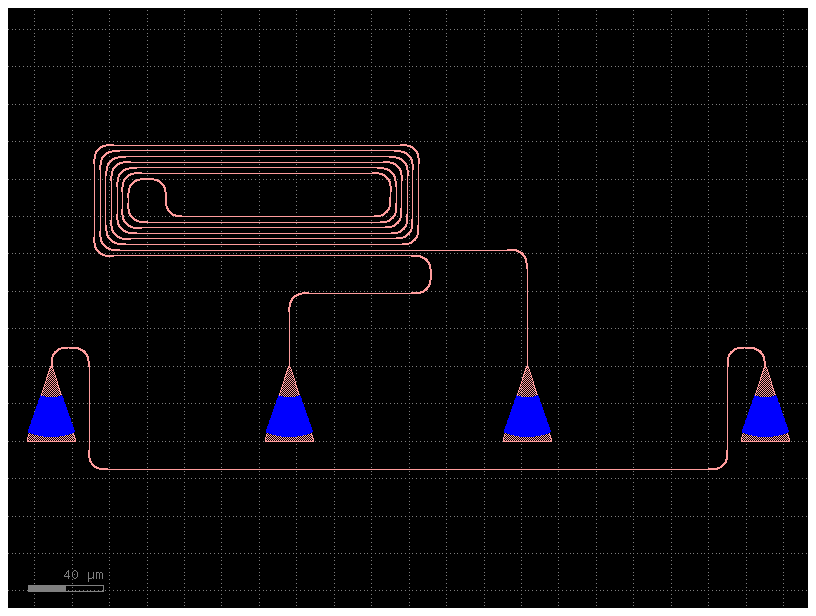

In [7]:
# which is equivalent to
spiral_te = gf.compose(
    gf.routing.add_fiber_array,
    gf.components.spiral,
)
c = spiral_te(length=100)
c.plot()

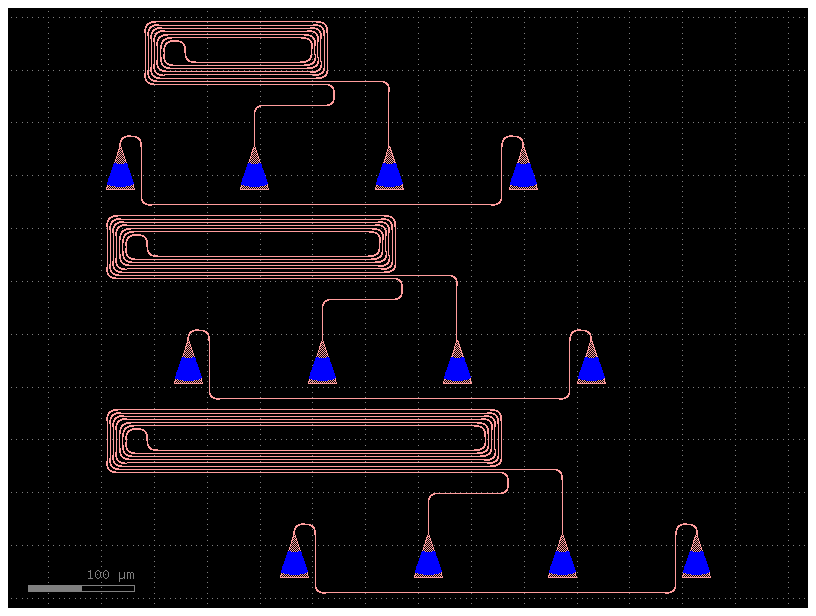

In [8]:
spiral_te = gf.compose(
    gf.routing.add_fiber_array,
    gf.components.spiral,
)
sweep = [spiral_te(length=length) for length in [100, 200, 300]]
m = gf.pack(sweep)
c = m[0]
c.plot()

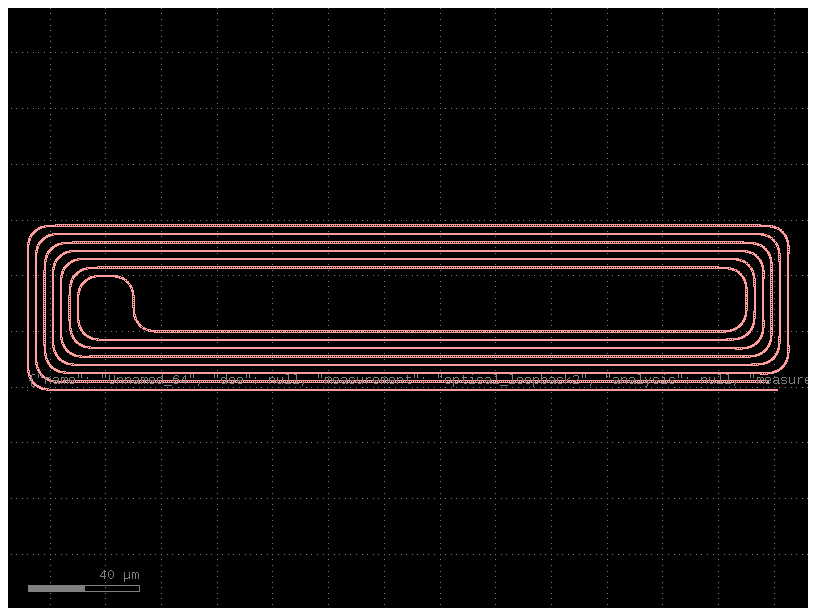

In [9]:
import gdsfactory as gf

c = gf.Component()
d = c << gf.components.spiral(length=200)
c.info["measurement"] = "optical_loopback2"
c = gf.labels.add_label_json(c)
c.show()
c.plot()

In [10]:
def add_label_json(component):
    """Add label json and component.info."""
    component.info["measurement"] = "optical_loopback2"
    component = gf.labels.add_label_json(component)
    return component

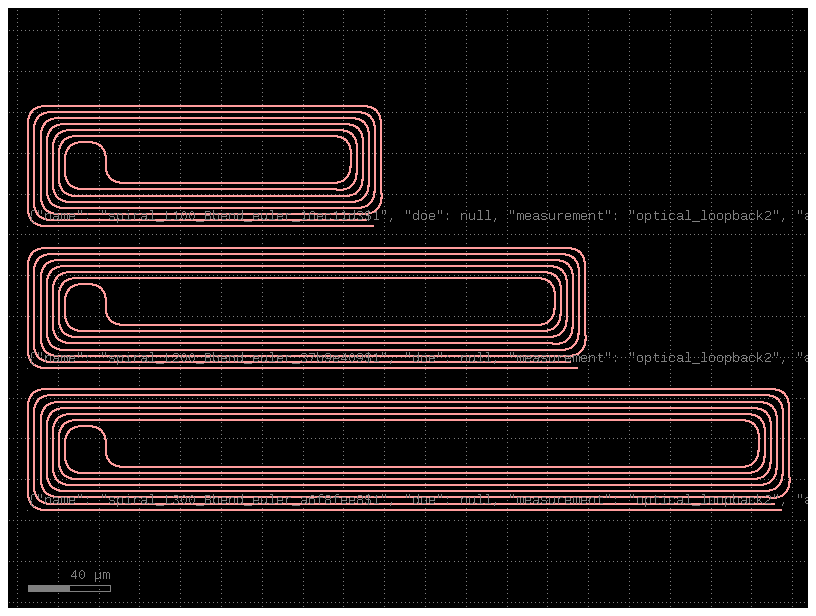

In [11]:
sweep = [
    add_label_json(gf.components.spiral(length=length).copy()) for length in [100, 200, 300]
]
m = gf.pack(sweep)
c = m[0]
c.show()
c.plot()

You can also add some physical labels that will be fabricated.
For example you can add prefix `S` at the `north-center` of each spiral using `text_rectangular` which is DRC clean and anchored on `nc` (north-center)

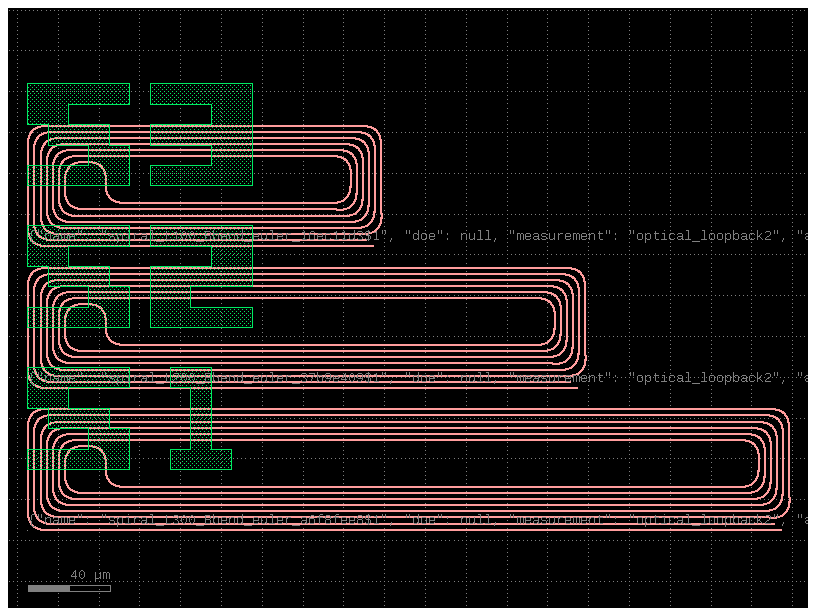

In [12]:
text_metal = partial(gf.components.text_rectangular_multi_layer, layers=("M1",))

m = gf.pack(sweep, text=text_metal, text_anchors=("cw",), text_prefix="s")
c = m[0]
c.show()
c.plot()

## Grid

You can also pack components with a constant spacing.

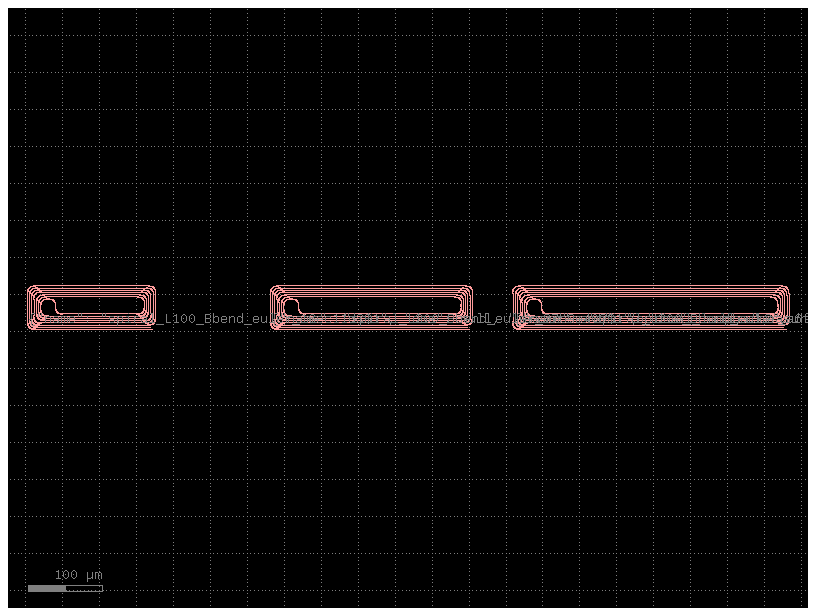

In [13]:
g = gf.grid(sweep)
g.plot()

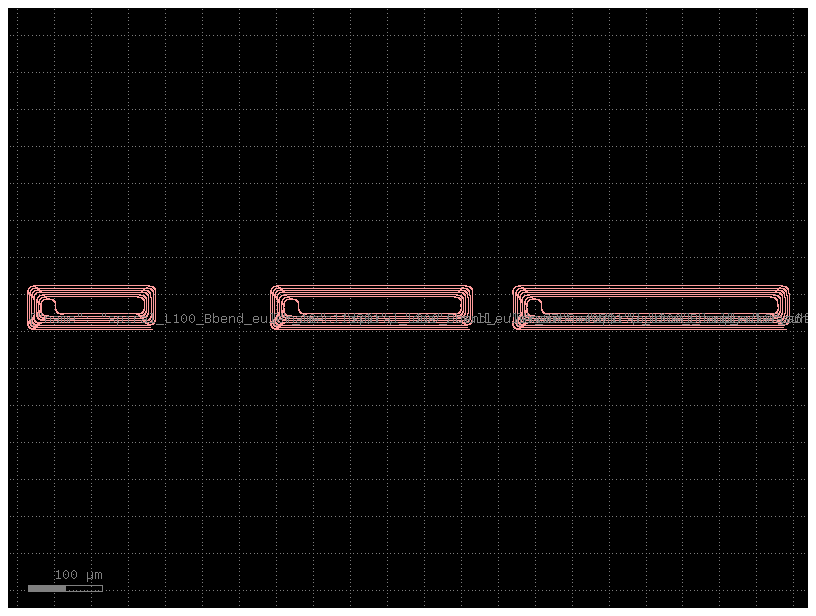

In [14]:
gh = gf.grid(sweep, shape=(1, len(sweep)))
gh.plot()

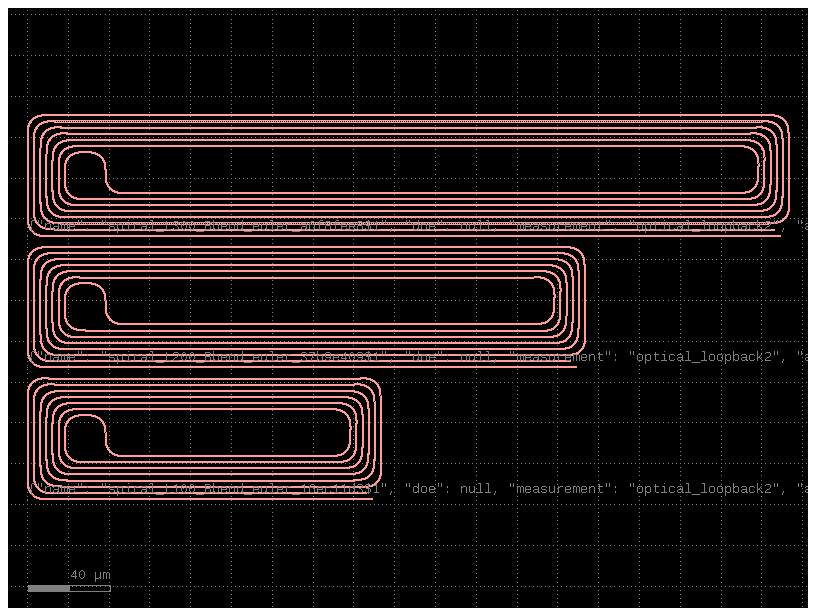

In [15]:
gh_ymin = gf.grid(sweep, shape=(len(sweep), 1), align_x="xmin")
gh_ymin.plot()

You can also add text labels to each element of the sweep

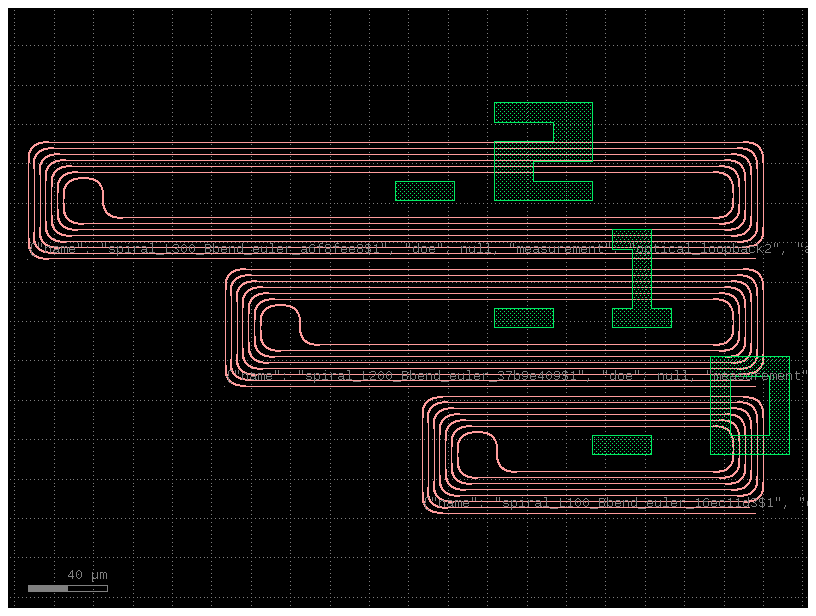

In [16]:
gh_ymin = gf.grid_with_text(
    sweep, shape=(len(sweep), 1), align_x="xmax", text=text_metal
)
gh_ymin.plot()

You have 2 ways of defining a mask:

1. in python
2. in YAML


## 1. Component in python

You can define a Component top cell reticle or die using `grid` and `pack` python functions.

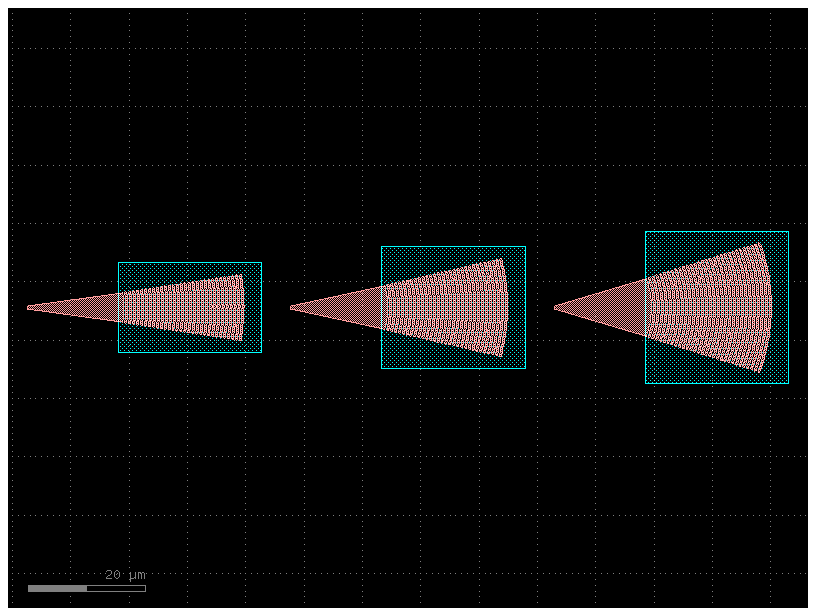

In [17]:
text_metal3 = partial(gf.components.text_rectangular_multi_layer, layers=((49, 0),))
grid = partial(gf.grid_with_text, text=text_metal3)
pack = partial(gf.pack, text=text_metal3)

gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings = grid(gratings_sweep, text=None)
gratings.plot()

In [18]:
gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings_loss_sweep = [
    gf.components.grating_coupler_loss_fiber_array(grating_coupler=grating)
    for grating in gratings_sweep
]
gratings = grid(
    gratings_loss_sweep, shape=(1, len(gratings_loss_sweep)), spacing=(40, 0)
)
gratings.plot()

AttributeError: module 'gdsfactory.components' has no attribute 'grating_coupler_loss_fiber_array'

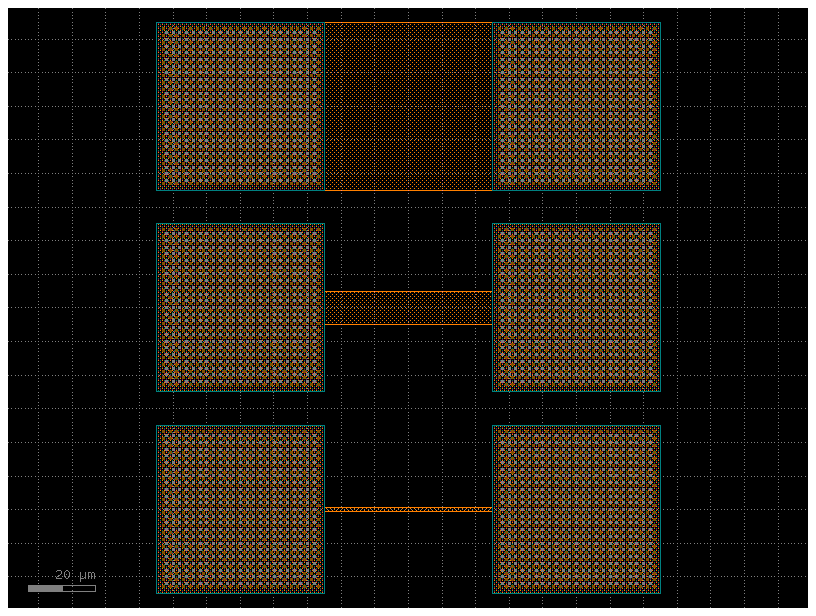

In [19]:
sweep_resistance = [
    gf.components.resistance_sheet(width=width) for width in [1, 10, 50]
]
resistance = gf.pack(sweep_resistance)[0]
resistance.plot()

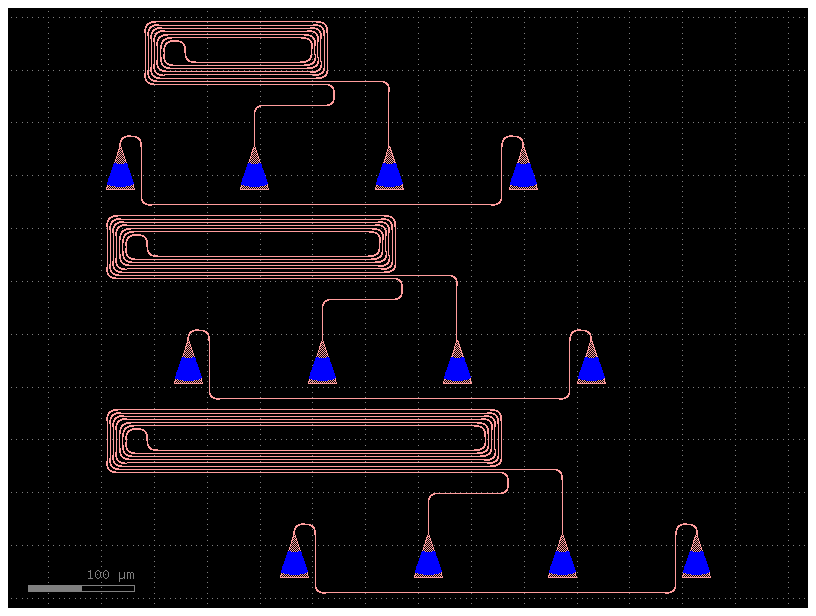

In [20]:
spiral_te = gf.compose(
    gf.routing.add_fiber_array,
    gf.components.spiral,
)
sweep_spirals = [spiral_te(length=length) for length in [100, 200, 300]]
spirals = gf.pack(sweep_spirals)[0]
spirals.plot()

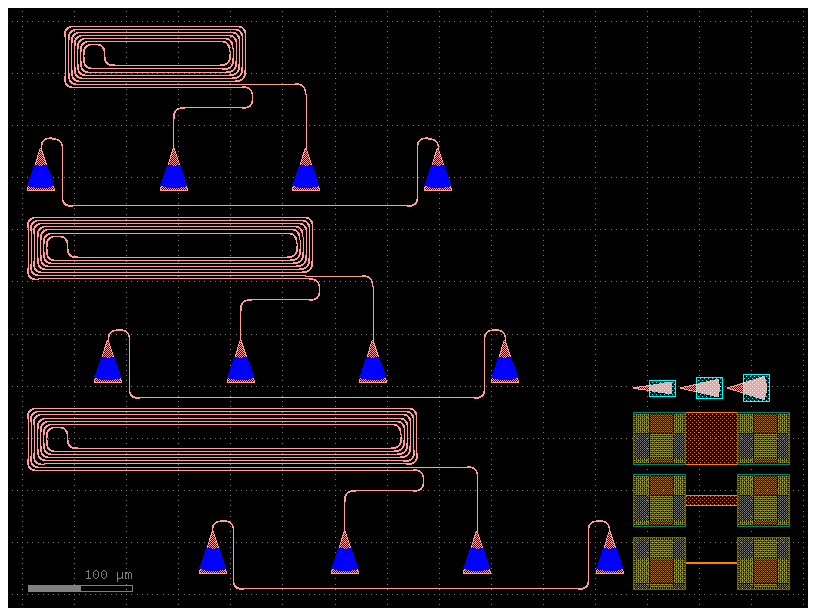

In [21]:
mask = gf.pack([spirals, resistance, gratings])[0]
mask.plot()

As you can see you can define your mask in a single line.

For more complex mask, you can also create a new cell to build up more complexity


In [23]:
@gf.cell
def mask():
    c = gf.Component()
    c << gf.pack([spirals, resistance, gratings])[0]
    c << gf.components.seal_ring(c)
    return c


c = mask()
c.plot()

IndexError: list index out of range

## 2. Component in YAML

You can also define your component in YAML format thanks to `gdsfactory.read.from_yaml`

You need to define:

- instances
- placements
- routes (optional)

and you can leverage:

1. `pack_doe`
2. `pack_doe_grid`

### 2.1 pack_doe

`pack_doe` places components as compact as possible.

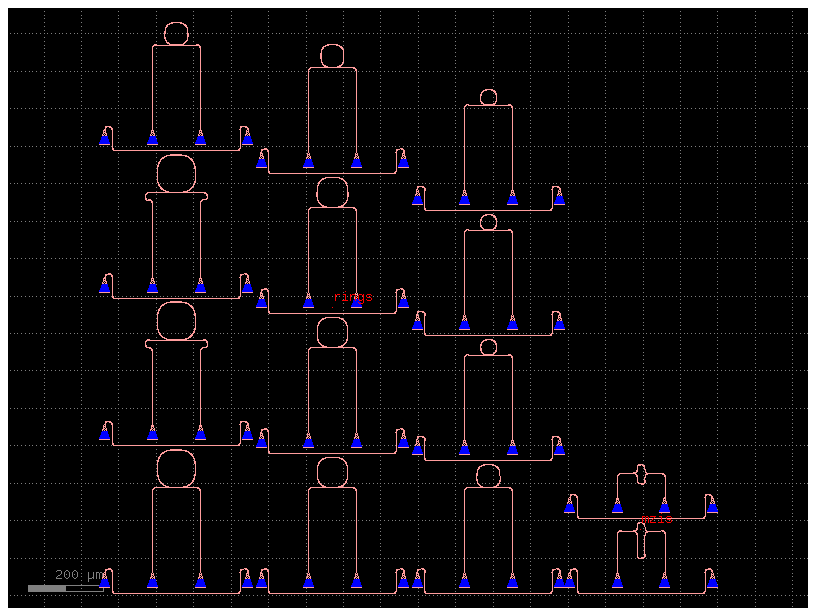

In [24]:
c = gf.read.from_yaml(
    """
name: mask_grid

instances:
  rings:
    component: pack_doe
    settings:
      doe: ring_single
      settings:
        radius: [30, 50, 20, 40]
        length_x: [1, 2, 3]
      do_permutations: True
      function:
        function: add_fiber_array
        settings:
            fanout_length: 200

  mzis:
    component: pack_doe
    settings:
      doe: mzi
      settings:
        delta_length: [10, 100]
      function: add_fiber_array

placements:
  rings:
    xmin: 50

  mzis:
    xmin: rings,east
"""
)

c.plot()

### 2.2 pack_doe_grid

`pack_doe_grid` places each component on a regular grid

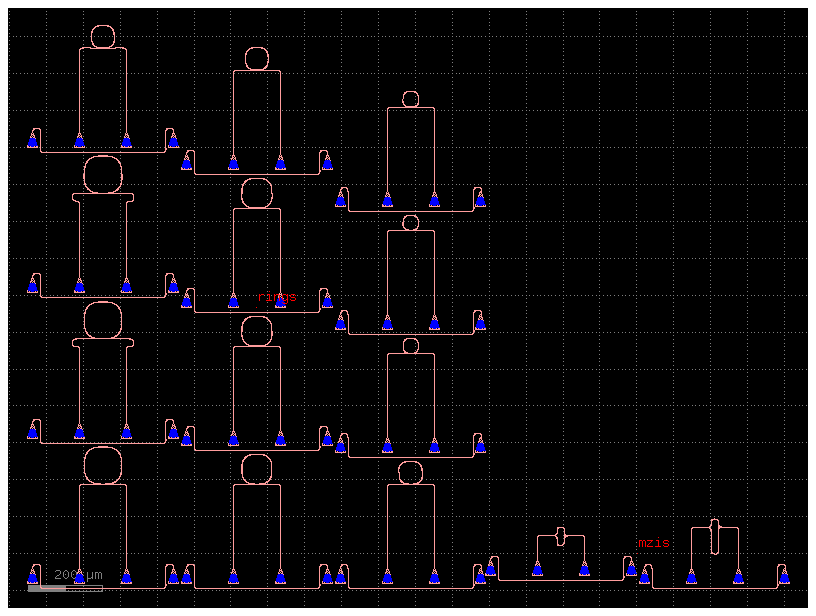

In [25]:
c = gf.read.from_yaml(
    """
name: mask_compact

instances:
  rings:
    component: pack_doe
    settings:
      doe: ring_single
      settings:
        radius: [30, 50, 20, 40]
        length_x: [1, 2, 3]
      do_permutations: True
      function:
        function: add_fiber_array
        settings:
            fanout_length: 200


  mzis:
    component: pack_doe_grid
    settings:
      doe: mzi
      settings:
        delta_length: [10, 100]
      do_permutations: True
      spacing: [10, 10]
      function: add_fiber_array

placements:
  rings:
    xmin: 50

  mzis:
    xmin: rings,east
"""
)
c.plot()

## Automated testing exposing all ports

You can promote all the ports that need to be tested to the top level component and then write a CSV test manifest.

This is the recommended way for measuring components that have electrical and optical port.

In [26]:
from gdsfactory.generic_tech.cells import add_fiber_array_optical_south_electrical_north

test_info_spirals = dict(
    doe="spirals_sc",
    measurement="optical_loopback4",
    analysis="optical_loopback4_spirals",
)
test_info_mzi_heaters = dict(
    doe="mzis_heaters",
    analysis="mzi_heater",
    measurement="optical_loopback4_heater_sweep",
)
test_info_ring_heaters = dict(
    doe="ring_heaters",
    analysis="ring_heater",
    measurement="optical_loopback2_heater_sweep",
)


def sample_reticle() -> gf.Component:
    """Returns MZI with TE grating couplers."""
    mzis = [
        gf.components.mzi2x2_2x2_phase_shifter(length_x=length, auto_rename_ports=False)
        for length in [100, 200, 300]
    ]
    rings = [
        gf.components.ring_single_heater(length_x=length_x) for length_x in [10, 20, 30]
    ]

    spirals_te = [
        gf.routing.add_fiber_array(
            gf.components.spiral(
                length=length,
            )
        )
        for length in [0, 100, 200]
    ]
    mzis_te = [
        add_fiber_array_optical_south_electrical_north(
            component=mzi,
            electrical_port_names=("top_l_e2", "top_r_e2"),
        )
        for mzi in mzis
    ]
    rings_te = [
        add_fiber_array_optical_south_electrical_north(
            component=ring,
            electrical_port_names=("l_e2", "r_e2"),
        )
        for ring in rings
    ]

    for component in mzis_te:
        component.info.update(test_info_mzi_heaters)

    for component in rings_te:
        component.info.update(test_info_ring_heaters)

    for component in spirals_te:
        component.info.update(test_info_spirals)

    components = mzis_te + rings_te + spirals_te
    return gf.pack(components)[0]


c = sample_reticle()
c.show()
c.plot()

ModuleNotFoundError: No module named 'gdsfactory.generic_tech.cells'

In [27]:
c.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer ┃ center ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━┩
└──────┴───────┴─────────────┴───────┴────────┴───────────┘

In [28]:
df = gf.labels.get_test_manifest(c)
df

AttributeError: module 'gdsfactory.labels' has no attribute 'get_test_manifest'

In [ ]:
df.to_csv("test_manifest.csv")

In [ ]:
def sample_reticle_grid() -> gf.Component:
    """Returns sample reticle with grid packer."""
    from gdsfactory.generic_tech.cells import (
        add_fiber_array_optical_south_electrical_north,
    )

    mzis = [
        gf.components.mzi2x2_2x2_phase_shifter(length_x=length, auto_rename_ports=False)
        for length in [100, 200, 300]
    ]
    rings = [
        gf.components.ring_single_heater(length_x=length_x) for length_x in [10, 20, 30]
    ]

    spirals_te = [
        gf.routing.add_fiber_array(
            gf.components.spiral(
                length=length,
            )
        )
        for length in [0, 100, 200]
    ]
    mzis_te = [
        add_fiber_array_optical_south_electrical_north(
            component=mzi,
            electrical_port_names=["top_l_e2", "top_r_e2"],
        )
        for mzi in mzis
    ]
    rings_te = [
        add_fiber_array_optical_south_electrical_north(
            component=ring,
            electrical_port_names=["l_e2", "r_e2"],
        )
        for ring in rings
    ]

    for component in mzis_te:
        component.info.update(test_info_mzi_heaters)

    for component in rings_te:
        component.info.update(test_info_ring_heaters)

    for component in spirals_te:
        component.info.update(test_info_spirals)

    components = mzis_te + rings_te + spirals_te
    return gf.grid(components)


c = sample_reticle_grid()
c.plot()

In [ ]:
df = gf.labels.get_test_manifest(c)
df

In [ ]:
df.to_csv("test_manifest.csv")

You can see a test manifest example [here](https://docs.google.com/spreadsheets/d/1845m-XZM8tZ1tNd8GIvAaq7ZE-iha00XNWa0XrEOabc/edit#gid=233591479)